<a href="https://colab.research.google.com/github/Murcha1990/Raiff_practical_ML/blob/main/Lecture_9_full_pipeline/Raiff_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи поиска оттоковых клиентов

Пройдем по всей схеме:
* загрузка и анализ данных
* построение базовой модели и оценка ее качества
* улучшение качества прогноза
* анализ результатов
* применение модели к новым клиентам

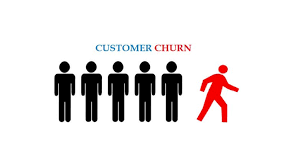

## <font color='green'>1. Загрузка данных (и их первичный анализ)</font>

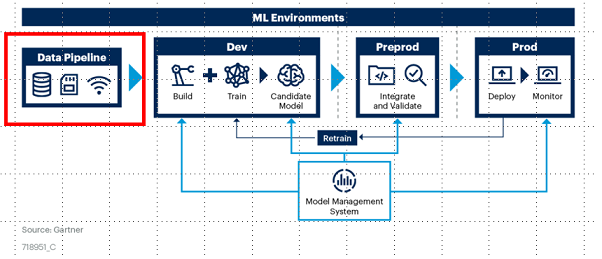

In [ ]:
!pip install catboost -q

In [370]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [377]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

In [377]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

In [373]:
import psycopg2

conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [374]:
import pandas as pd

query = "SELECT * from public.clients"
data = pd.read_sql_query(query, conn)

conn.close()

In [377]:
data.head()

## <font color='green'>2.1. Построение базовой модели</font>



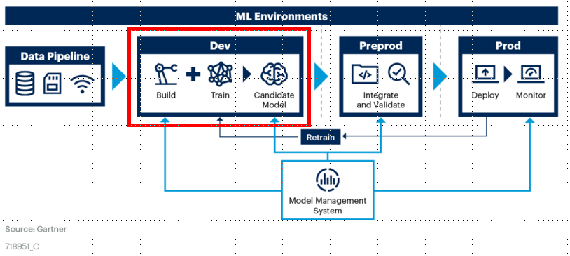

Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [ ]:
X = data.drop('churn', axis=1) # матрица объект-признак
y = data['churn'] # целевая переменная

Выкинем излишние признаки.

In [ ]:
X.drop(['totaldaycharge','totalevecharge','totalnightcharge','totalintlcharge'], axis=1, inplace=True)

Пока что выкинем нечисловые признаки.

In [ ]:
X_full = X.copy()
X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)

Разобъем данные на тренировочную и тестовую части.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

Масштабируем данные.

In [377]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [377]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression() # объявление модели
model.fit(Xtrain, ytrain) # обучение модели

In [ ]:
pred_test = model.predict_proba(Xtest)[:,1] # предсказание классов

In [377]:
roc_auc_score(ytest, pred_test)

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества моделей бинарной классификации полезно смотреть на матрицу ошибок.

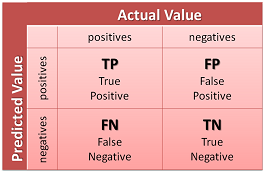

In [377]:
classes = pred_test > 0.2

confusion_matrix(ytest, classes)

In [377]:
recall_score(ytest, classes)

## <font color='green'>3. Улучшение качества моделей и их интерпретация </font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [377]:
Xtrain.head()

Закодируем при помощи OneHot-encoding категориальные столбцы.

In [ ]:
categorical = ['state','areacode','voicemailplan','internationalplan']

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

Xtrain_ohe = pd.DataFrame(OH_encoder.fit_transform(Xtrain[categorical]), columns=OH_encoder.get_feature_names())
Xtest_ohe = pd.DataFrame(OH_encoder.transform(Xtest[categorical]), columns=OH_encoder.get_feature_names())

In [377]:
Xtrain_ohe.head()

Масштабируем числовые столбцы.

In [377]:
numeric = [col for col in Xtrain.columns if col not in categorical]
numeric

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Xtrain_num = Xtrain[numeric]
Xtest_num = Xtest[numeric]

scaler = MinMaxScaler()
scaler.fit(Xtrain_num)

Xtrain_num = pd.DataFrame(scaler.transform(Xtrain_num), columns=Xtrain_num.columns)
Xtest_num = pd.DataFrame(scaler.transform(Xtest_num), columns=Xtest_num.columns)

Собираем итоговые матрицы признаков.

In [ ]:
Xtrain_good = pd.concat([Xtrain_num, Xtrain_ohe], axis=1)
Xtest_good = pd.concat([Xtest_num, Xtest_ohe], axis=1)

In [377]:
Xtrain_good.head()

### <font color='green'>3.1. Логистическая регрессия на всех признаках </font>

In [ ]:
model = LogisticRegression()
model.fit(Xtrain_good, ytrain) 

probs = model.predict_proba(Xtest_good)[:,1]

In [377]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ytest, probs)

In [377]:
pd.Series(model.coef_[0], index=Xtrain_good.columns).nlargest(5).plot(kind='barh',color='green')
plt.show()
pd.Series(model.coef_[0], index=Xtrain_good.columns).nsmallest(5).plot(kind='barh',color='red')
plt.show()

### <font color='green'>3.2. CatBoost на всех признаках </font>

In [ ]:
gbm = CatBoostClassifier(iterations=300, #сколько деревьев
                          depth=2, #глубина каждого дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(Xtrain_good, ytrain)
gbm_preds = gbm.predict_proba(Xtest_good)[:,1]

In [377]:
roc_auc_score(ytest, gbm_preds)

In [377]:
pd.Series(gbm.feature_importances_, index=Xtrain_good.columns).nlargest(10).plot(kind='barh',color='blue')
plt.show()

### <font color='green'>3.3. CatBoost с внутренним кодированием категориальных признаков </font>

In [377]:
Xtrain.head()

In [ ]:
cat_features = [0, 2, 3, 4]

In [ ]:
gbm2 = CatBoostClassifier(iterations=300, #сколько деревьев
                          depth=2, #глубина каждого дерева
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm2.fit(Xtrain, ytrain, cat_features=cat_features)
gbm2_preds = gbm.predict_proba(Xtest)[:,1]

In [377]:
roc_auc_score(ytest, gbm2_preds)

In [377]:
pd.Series(gbm2.feature_importances_, index=Xtrain.columns).nlargest(10).plot(kind='barh',color='blue')
plt.show()

## <font color='green'>4. Получение предсказаний на новых данных. </font>


Вручную добавим данные о новом клиенте.

In [ ]:
NewData = pd.DataFrame(columns=Xtrain.columns)
NewData = NewData.append({'state' : 'CO', 
                'accountlength' : 71,
                'areacode' : 415,
                'internationalplan' : 'No',
                'voicemailplan' : 'No',
                'numbervmailmessages': 0,
                'totaldayminutes' : 211.2, 
                'totaldaycalls' : 70.0,
                'totaleveminutes' : 252.7,
                'totalevecalls' : 122.0,
                'totalnightminutes' : 225.8,
                'totalnightcalls' : 104.0,
                'totalintlminutes' : 12.3,
                'totalintlcalls' : 3.0,
                'customerservicecalls' : 0 
}, ignore_index=True)

NewData.head()

,state,accountlength,areacode,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaleveminutes,totalevecalls,totalnightminutes,totalnightcalls,totalintlminutes,totalintlcalls,customerservicecalls
0,CO,71,415,No,No,0,30,70.0,252.7,122.0,225.8,104.0,12.3,3.0,10


Обработаем данные так же, как делали это при обучении модели.

In [ ]:
NewData_ohe = pd.DataFrame(OH_encoder.transform(NewData[categorical]), columns=OH_encoder.get_feature_names())
NewData_num = pd.DataFrame(scaler.transform(NewData[numeric]), columns=NewData[numeric].columns)

NewData = pd.concat([NewData_num, NewData_ohe], axis=1)

Делаем предсказание при помощи бустинга.

In [ ]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.05090117])

Согласно модели, этот клиент скорее всего не покинет компанию? А почему?

* Попробуем увеличить число звонков в службу поддержки (поставим 10).

In [ ]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.24893636])

* А еще уменьшим `totaldayminutes` до 30.

In [ ]:
gbm_preds = gbm.predict_proba(NewData)[:,1]

gbm_preds

array([0.96165054])